In [1]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)

In [2]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','RMS'])
    groupres = {} #results on each group for each model
    
    acc_all=[]; acc_train=[] 
    f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
    auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
    RMS_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        #yscore = clf.predict_proba(Xte)
        #yscore = yscore[:,1]

        #accuracy on train set
        
        RMS=0
        for yp,yt in zip(ypred,y):
            RMS += ((yp - yt)**2)
        RMS = RMS / len(y)
        RMS = math.sqrt(RMS)
        
        RMS_all.append(RMS)
        
        groupres[model_name] = {'RMS':RMS_all}
        
        r = pd.DataFrame({'model':model_name, 'RMS':np.nanmean(RMS_all)},index=[0])
        results = pd.concat((results,r))
        
    return results, groupres

In [3]:
folder_path = r'Z:CIS-PD Study'
subjects_path = r'Z:\CIS-PD Study\Subjects' #Windows remote path
dict_path = 'Z:\CIS-PD Study\Data_dict'
scores_path = r'Z:\CIS-PD Study\Scores' #remote repo
features_path = r'Z:\CIS-PD Study\FeatureMatrix' #remote repo
results_path = r'C:\Users\LU-RT&O\Documents\Git\Results'

# Binary Classifier

## Watch

In [4]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

watch_res_freq_all = []

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    watch_res_all = pd.concat((watch_res_all,res))
    watch_res_freq_all.append(res_group)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.225, prec=0.485+/-0.324, rec=0.354+/-0.190, auprc=0.527+/-0.282, auroc=0.772+/-0.186
45
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.368+/-0.240, prec=0.482+/-0.330, rec=0.363+/-0.199, auprc=0.523+/-0.281, auroc=0.778+/-0.181
40
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.225, prec=0.485+/-0.324, rec=0.354+/-0.190, auprc=0.527+/-0.282, auroc=0.772+/-0.186
35
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.351+/-0.215, prec=0.468+/-0.319, rec=0.314+/-0.191, auprc=0.502+/-0.282, auroc=0.767+/-0.186
30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.373+/-0.235, prec=0.502+/-0.331, rec=0.321+/-0.201, auprc=0.517+/-0.279, auroc=0.766+/-0.186
25
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.377+/-0.225, prec=0.489+/-0.312, rec=0.341+/-0.214, auprc=0.519+/-0.279, auroc=0.760+/-0.187
20
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.364+/-0.205, prec=0.504+/-0.315, rec=0.315+/-0.183, auprc=0.509+/-0.268, auroc=0.750+/-0.185
15
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.301+/-0.179, prec=0.441+/-0.303, rec=0.279+/-0.191, auprc=0.448+/-0.256, auroc=0.715+/-0.175
10
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.280+/-0.152, prec=0.416+/-0.277, rec=0.298+/-0.268, auprc=0.451+/-0.231, auroc=0.681+/-0.185
5
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-d

f1_test=0.228+/-0.186, prec=0.418+/-0.346, rec=0.184+/-0.162, auprc=0.497+/-0.285, auroc=0.603+/-0.189
Elapsed time = 5.217 min


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


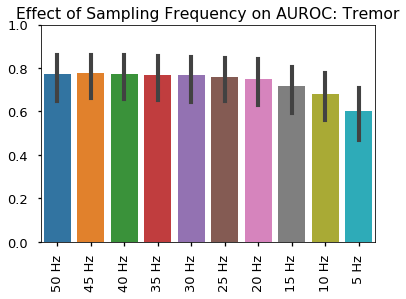

In [5]:
groups = watch_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(watch_res_freq_all)):
    if len(watch_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(watch_res_freq_all[i]['Random Forest']['auroc'])
        watch_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = watch_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = watch_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/BinaryWatchTremor.png',format='png',dpi=1000)

In [6]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

watch_res_freq_all = []

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    watch_res_all = pd.concat((watch_res_all,res))
    watch_res_freq_all.append(res_group)
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
f1_test=0.575+/-0.228, prec=0.594+/-0.280, rec=0.692+/-0.183, auprc=0.623+/-0.269, auroc=0.613+/-0.132
45
Training Random Forest
f1_test=0.576+/-0.231, prec=0.590+/-0.284, rec=0.691+/-0.178, auprc=0.630+/-0.275, auroc=0.621+/-0.127
40
Training Random Forest
f1_test=0.575+/-0.228, prec=0.594+/-0.280, rec=0.692+/-0.183, auprc=0.623+/-0.269, auroc=0.613+/-0.132
35
Training Random Forest
f1_test=0.584+/-0.229, prec=0.597+/-0.281, rec=0.698+/-0.168, auprc=0.620+/-0.267, auroc=0.622+/-0.127
30
Training Random Forest
f1_test=0.584+/-0.229, prec=0.596+/-0.282, rec=0.703+/-0.171, auprc=0.624+/-0.267, auroc=0.626+/-0.122
25
Training Random Forest
f1_test=0.575+/-0.220, prec=0.593+/-0.281, rec=0.685+/-0.169, auprc=0.628+/-0.269, auroc=0.630+/-0.124
20
Training Random Forest
f1_test=0.585+/-0.226, prec=0.599+/-0.281, rec=0.696+/-0.170, auprc=0.626+/-0.265, auroc=0.635+/-0.119
15
Training Random Forest
f1_test=0.592+/-0.227, prec=0.598+/-0.280, rec=0.707+/-0.164, auprc=0.6

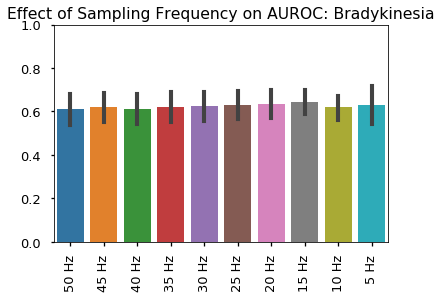

In [7]:
groups = watch_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(watch_res_freq_all)):
    if len(watch_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(watch_res_freq_all[i]['Random Forest']['auroc'])
        watch_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = watch_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = watch_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/BinaryWatchBrady.png',format='png',dpi=1000)

## Sensor

In [8]:
Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
Dataorig = Dataorig.reset_index(drop=True)
Dataorig

,Subject,Visit,Task,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,rangeX,rangeY,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000732,0.000535,0.000574,0.079929,0.054974,...,2.245687e-05,3.957944,17.453930,-4.201932e-05,0.004184,-0.066907,0.425589,0.895181,1.171897,0.991753
1,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000591,0.000492,0.000475,0.059164,0.073760,...,1.397226e-05,1.614171,1.790243,-4.759900e-05,0.004053,-0.367448,1.388203,0.952226,0.906698,1.149938
2,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000557,0.000494,0.000422,0.063106,0.073760,...,3.632781e-06,1.311572,0.411762,2.628928e-06,0.003752,-0.306528,1.186797,0.890457,0.892128,1.325102
3,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000472,0.000360,0.000383,0.056094,0.042008,...,5.813128e-06,1.514496,1.703693,1.555026e-05,0.003292,0.132470,0.111247,1.015921,1.299535,1.247401
4,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000317,0.000244,0.000281,0.033473,0.029404,...,3.997959e-06,2.311033,5.007486,4.050112e-05,0.002590,0.053671,0.837272,1.289370,1.392917,1.263504
5,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000212,0.000133,0.000164,0.023385,0.015235,...,8.641504e-07,1.570975,2.379631,-1.363500e-05,0.002120,0.145974,-0.105358,1.508184,1.839541,1.900959
6,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000300,0.000183,0.000163,0.052590,0.034331,...,7.600760e-07,2.491438,5.976862,1.335471e-05,0.002163,0.067363,0.325810,1.261292,1.396683,1.971345
7,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000382,0.000188,0.000178,0.065765,0.034331,...,1.214683e-06,1.811544,2.483537,3.085347e-05,0.002284,-0.106633,0.139448,0.997457,1.333003,1.897487
8,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000319,0.000140,0.000178,0.045893,0.015299,...,1.484381e-06,2.521806,6.361772,-1.067269e-05,0.002178,-0.074210,-0.255324,1.242819,1.703678,1.831201
9,1004,2 Weeks: Time 0,Motor #1: Standing,NaN,0.0,0.000216,0.000145,0.000167,0.019202,0.012342,...,1.300386e-06,2.918695,8.016578,-3.619097e-07,0.002062,0.023303,-0.285454,1.611734,1.560382,1.882209


In [9]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

sensor_res_freq_all = []

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:
    
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)
    
    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    sensor_res_all = pd.concat((sensor_res_all,res))
    sensor_res_freq_all.append(res_group)

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
60
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
55
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
50
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
45
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
40
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
35
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
30
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
25
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
20
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
15
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
10
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
5
Rows w Tremor 4980/16668 = 0.30
Training Random Forest


C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:444: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\Public\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


f1_test=0.333+/-0.223, prec=0.488+/-0.303, rec=0.278+/-0.190, auprc=0.483+/-0.259, auroc=0.709+/-0.152
Elapsed time = 10.727 min


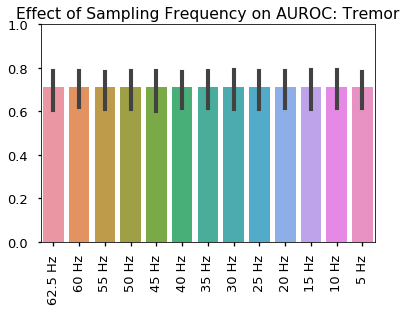

In [10]:
groups = sensor_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(sensor_res_freq_all)):
    if len(sensor_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(sensor_res_freq_all[i]['Random Forest']['auroc'])
        sensor_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = sensor_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = sensor_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/BinarySensorTremor.png',format='png',dpi=1000)

In [11]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

sensor_res_freq_all = []

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:
    
    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res['auroc std'] = np.nanstd(res_group['Random Forest']['auroc'])
    res = res[['Sampling Rate','auroc','auroc std']]
    sensor_res_all = pd.concat((sensor_res_all,res))
    sensor_res_freq_all.append(res_group)

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.598+/-0.233, prec=0.613+/-0.289, rec=0.711+/-0.160, auprc=0.622+/-0.279, auroc=0.633+/-0.106
60
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.598+/-0.233, prec=0.613+/-0.289, rec=0.711+/-0.160, auprc=0.622+/-0.279, auroc=0.633+/-0.106
55
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.598+/-0.233, prec=0.613+/-0.289, rec=0.711+/-0.160, auprc=0.622+/-0.279, auroc=0.633+/-0.106
50
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.598+/-0.233, prec=0.613+/-0.289, rec=0.711+/-0.160, auprc=0.622+/-0.279, auroc=0.633+/-0.106
45
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.598+/-0.233, prec=0.613+/-0.289, rec=0.711+/-0.160, auprc=0.622+/-0.279, auroc=0.633+/-0.106
40
Rows w Bradykinesia 7686/13739 = 0.56
Training Random Forest
f1_test=0.598+/-0.233, prec=0.613+/-0.289, rec=0.711+/-0.160, auprc=0.622+/-0.279, auroc=0.633+/-0.

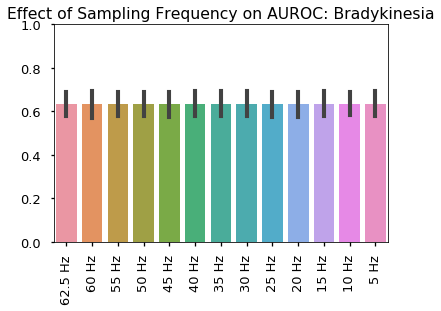

In [12]:
groups = sensor_res_all['Sampling Rate'].values
auc_mean = []; auc_std = []
aucdf = pd.DataFrame()
for i in range(len(sensor_res_freq_all)):
    if len(sensor_res_freq_all[i]['Random Forest']['auroc']) < 7:
        L = len(sensor_res_freq_all[i]['Random Forest']['auroc'])
        sensor_res_freq_all[i]['Random Forest']['auroc'] += (list(np.nan*np.ones(7-L)))
    aucdf[groups[i]] = sensor_res_freq_all[i]['Random Forest']['auroc']   
    tremor_auc = sensor_res_freq_all[i]['Random Forest']['auroc']
    auc_mean.append(np.nanmean(tremor_auc)) #mean across visits
    auc_std.append(np.nanstd(tremor_auc))

sns.barplot(data=aucdf)
ax=plt.xticks(rotation=90)
plt.ylim([0,1.0])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/BinarySensorBrady.png',format='png',dpi=1000)

# Multiple Class Classifier

## Watch

In [13]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 4.424 min


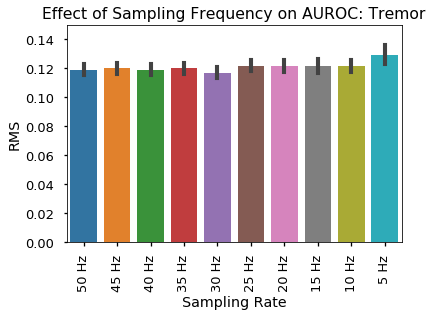

In [14]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/MulticlassWatchTremor.png',format='png',dpi=1000)

In [15]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 3.596 min


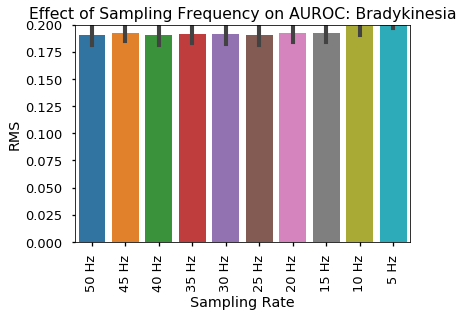

In [16]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/MulticlassWatchBrady.png',format='png',dpi=1000)

## Sensor

In [17]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 9.342 min


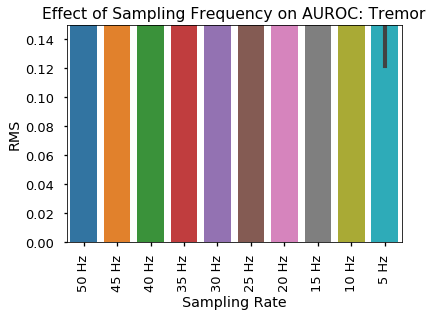

In [18]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/MulticlassSensorTremor.png',format='png',dpi=1000)

In [19]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 8.142 min


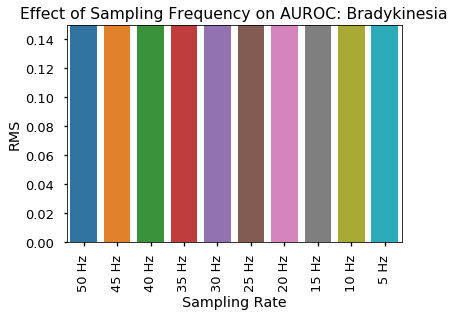

In [20]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/MulticlassSensorBrady.png',format='png',dpi=1000)

# Regressor

## Watch

In [22]:
symptom = 'Tremor'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 29.516 min


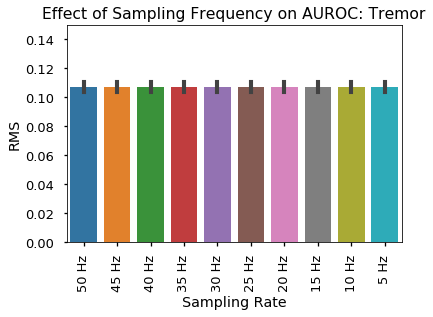

In [23]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/RegressorWatchTremor.png',format='png',dpi=1000)

In [24]:
symptom = 'Bradykinesia'

watch_res_all = pd.DataFrame()

t1=time.time()

for freq in [50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    watch_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 22.262 min


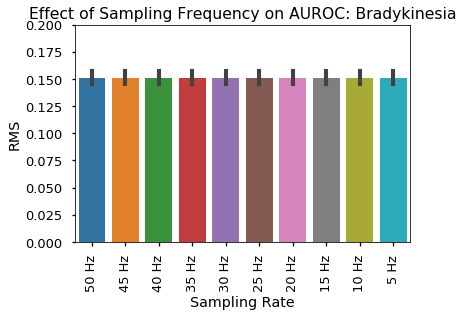

In [25]:
groups = watch_res_all['Sampling Rate']
RMS = watch_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.20])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/RegressorWatchBrady.png',format='png',dpi=1000)

## Sensor

In [26]:
symptom = 'Tremor'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 47.916 min


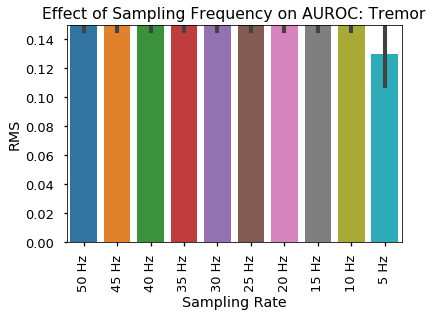

In [27]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Tremor')
plt.savefig('Results/Downsample/RegressorSensorTremor.png',format='png',dpi=1000)

In [28]:
symptom = 'Bradykinesia'

sensor_res_all = pd.DataFrame()

t1=time.time()

for freq in [62.5,60,55,50,45,40,35,30,25,20,15,10,5]:

    print(freq)

    Dataorig = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    Dataorig = Dataorig.reset_index(drop=True)

    Dataorig=Dataorig[Dataorig.Subject!=1020]

    #remove nan rows for current symptom
    Data = Dataorig.copy() #original unmodified dataframe
    Data=Data[~Data[symptom].isnull()]
    for s in Data.columns.values[4:]:
        Data = Data[Data[s]<np.finfo(np.float32).max]
    Data=Data.reset_index(drop=True) #reset index

    X = Data.iloc[:,5:].as_matrix()
    # X = StandardScaler().fit_transform(X)
    fnames = Data.iloc[:,5:].columns.values

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    #print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestRegressor(n_estimators=50,random_state=2)]          
    model_name = ['Random Forest']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOMultiClass(Data,X,y,groups,models)
    res['Sampling Rate'] = str(freq) + ' Hz'
    res = res[['Sampling Rate','RMS']]
    sensor_res_all = pd.concat((watch_res_all,res))

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

62.5
Training Random Forest
60
Training Random Forest
55
Training Random Forest
50
Training Random Forest
45
Training Random Forest
40
Training Random Forest
35
Training Random Forest
30
Training Random Forest
25
Training Random Forest
20
Training Random Forest
15
Training Random Forest
10
Training Random Forest
5
Training Random Forest
Elapsed time = 40.469 min


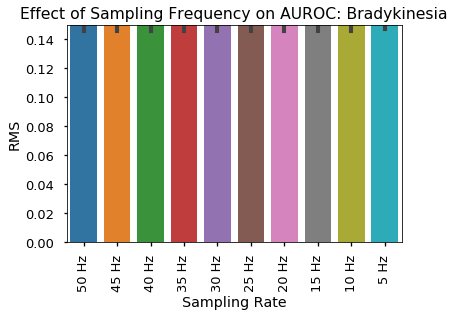

In [29]:
groups = sensor_res_all['Sampling Rate']
RMS = sensor_res_all['RMS']
sns.barplot(groups,RMS,ci='sd')
ax=plt.xticks(rotation=90)
plt.ylim([0,0.15])
plt.title('Effect of Sampling Frequency on AUROC: Bradykinesia')
plt.savefig('Results/Downsample/RegressorSensorBrady.png',format='png',dpi=1000)